<a href="https://colab.research.google.com/github/dguhanus/NLP_Classification/blob/main/Transformer_Classiciation_Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONTENTS

### 1. Importing Libraries
### 2. About the Data
### 3. Exploratory Data Analysis
       (a) Checking for Data Balancing
       (b) Identifying Max Lenght of Reviews
       (c) Review Overview
### 4. Text Processing
### 5. Dividing into Train,Test and Validation Data
### 6. Pre-Processing Pipeline
### 7. Roberta Model Fine Tuning
### 8. Model Testing
### 9. Result / Conclusion
### 10. References

# 1. Importing Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
### Extract the csv file from the uploaded tgz file
#import tarfile
data = pd.read_csv('/content/drive/MyDrive/Sentiment_Dataset/IMDB_Movie_Review/IMDB_50K_Dataset.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
data.sentiment = pd.Series(np.where(data.sentiment == 'positive', 1, 0), data.index)

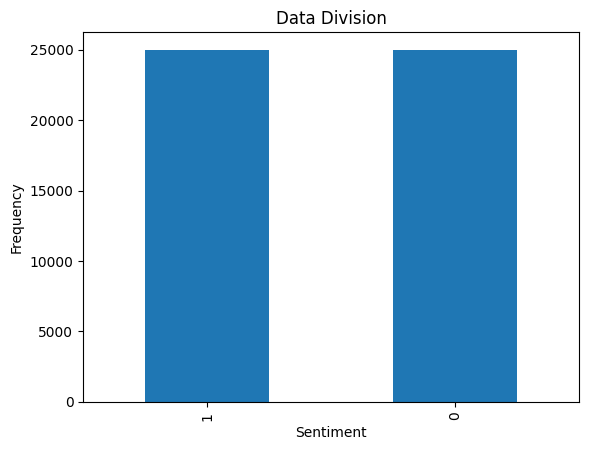

In [16]:
data['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Data Division')
plt.show()

In [17]:
import nltk
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
pos_df = data[data['sentiment']==1]
neg_df = data[data['sentiment']==0]
## Sorting the dataframe in descending order to view the logest strings
pos_df = pos_df.sort_values(by='review', ascending = False)
neg_df = neg_df.sort_values(by='review', ascending = False)

In [19]:
print(len(pos_df))

25000


Need to create a balanced dataset for positive and negative reviews of 1000 reviews for each

In [20]:
pos_first1000 = pos_df[:1000]
neg_first1000 = neg_df[:1000]

In [21]:
newdata = pd.concat([pos_first1000, neg_first1000], ignore_index=True, sort=False)
newdata.rename(columns={"review": "words"}, inplace=True)
newdata.head()

,words,sentiment
0,ý thýnk uzak ýs the one of the best films of a...,1
1,Film auteur Stephan Woloszczuk explores th...,1
2,~~I was able to see this movie yesterday morni...,1
3,{Possible spoilers coming up... you've been fo...,1
4,zero day is based of columbine high school mas...,1




Text Processing

The model that we intend to use would be an attention model so we don't want to remove any data that would enable the model to predict with accuracy. So we will be performing a broad text cleaning without any lemmatization or removal of stop words since these may be critical to mapping out the sentiment expressed. The following steps will be performed on the review text:

1. Conversion to Lower Case

2. Removal of delimiters

3. Removal of any links that may be pushed into the reviews

4. Removal of any special characters that can not essentially determine the sentiment

In [22]:
# function to clean the text following the above mention steps
def clean_review(review):
  # Converting to lower case
  review = review.lower()
  # removing delimters and tokenizing the text
  review = re.sub('<.*?>', '', review)
  review_tok = nltk.tokenize.word_tokenize(review)

  ## Removing Links
  review_tok = [ t for t in review_tok if not t.startswith("http://") and not t.startswith("https://")]

  # Removing special characters
  review_tok = [t.lstrip('@') for t in review_tok]
  review_tok = [t.lstrip('#') for t in review_tok]
  review_tok = [t.lstrip('/') for t in review_tok]

  # Rejoining the tokens to sentences/paras
  cleaned_review = ' '.join(review_tok)
  return cleaned_review


## CLeaning the review and then overwriting the existing dataframe
t = []
for i in newdata.words:
  t.append(clean_review(i))

newdata.drop('words', inplace= True, axis = 1)
newdata['words'] = t

In [23]:
shuffled = newdata.sample(frac=1)
newdata = shuffled
newdata.head()

,sentiment,words
242,1,"please , future writers , producers , director..."
1851,0,yet again one of the most misunderstood goddes...
639,1,a hilariously funny movie ! of course u got ta...
287,1,"let 's face it , you know what to expect when ..."
1675,0,ziab la ta'kol al lahem is an awful movie.this...


In [24]:
## Installing Required Packages
!pip install transformers tensorflow datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf

import nltk
import string

from transformers import AutoTokenizer
from datasets import Dataset
from transformers import TFAutoModelForSequenceClassification, AutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score , confusion_matrix , f1_score
import json


# 2. Summary

The data is regarding the sentiment expressed by movie watchers on the famous site 'Imdb'. It basically conisists of two columns with the first one depicting the review written by the viewer and the second column depicting the sentiment classification of the expressed opinion which can be either as 'positive' or 'negative'.

The data has a total of 50000 data points with variable lengths of the reviews. **The sentiment expressed makes it an essentially binary classification problem.**

To predict the expressed sentiment, we will use Transfer Learning for the predictions. In the same regard, **a 'Roberta Model' has been selected due to his inherent optimization of the BERT alongwith a larger training corpus.**

The biggest challenge that was found is that the length of the reviews is quite large on an average which in turn compromises the model accuracy to about considerably even with the model's ability to deal with a max length of 512. To counter this, multiple models were trained with a sequential reduction in the strings length to 128 which enabled us to have a **training accuracy of 94.91%, validation accuracy of 89.4% and test accuracy of 89.75%** with 3 epochs, which is markedly improved from the early results.

# 3. Exploratory Data Analysis

After importing the data, an overview overview of the data was carried out. It was learnt that the sentiment was an object with string values, so these were changed to 0 and 1 with '0' indicating a negative review while '1' indicating a positve review.

Subsequently, we checked for data balancing and found that the **data is perfectly balanced with 50% negative and 50% positive reviews**. We also checked for the lengths of the reviews and found the **higest review length to be '2911'** and **shortest review length to be '8'** with the **mean length of reviews to be '559' words**.

We can observe by looking at a few reviews two main things, the first is that the data has been scraped but there still remain some unnecessary html tags which need to be removed. The second more important thing that we can imbue from just manually looking at the reviews and the review sizes that we got earlier that the **text size is quite large in most instances and , therefore, a Sequential Model might not be the best choice here due to the limitation of memory associated with them.**

Based on our observation, we can proceed by keeping in view that we need a model that would be able to handle large text without any memory error. To do that, we can **make use of the tranformer models** that have recently shown to be quite effective. In this regard, we would be using **Transfer learning particularly the Roberta Model from Hugging Face library**.

## (a) Checking for Data Balancing

## (b) Approximating the length of reviews

In [26]:
#nltk.download('punkt')

In [27]:
#p = []
#n = []
#
## 1. Looping over the entire dataset to convert each review to first tokens
## 2. Counting number of words in each review
## 3. Adding the word number and id to a separate list for positive and negative sentiment
## 4. Converting the list of lists into a separate dataframe
#for i in range(len(data.review)):
#    temp = len(nltk.tokenize.word_tokenize(data.review[i]))
#    if data.sentiment[i] == 0:
#        n.append([temp,i])
#    else:
#        p.append([temp,i])
#
#
## Converting the list into 2 datframes for positive and negative review depicting word counts and idx
#pos_df = pd.DataFrame(p , columns = ['words', 'id'])
#neg_df = pd.DataFrame(n , columns = ['words' , 'id'])
#
## Sorting the dataframe in descending order to view the logest strings
#pos_df = pos_df.sort_values(by='words', ascending = False)
#neg_df = neg_df.sort_values(by='words', ascending = False)

In [28]:
#print (f'The longest review is {len(nltk.tokenize.word_tokenize(data.review[40521]))} words long.')
#print (f'The shortest review is {len(nltk.tokenize.word_tokenize(data.review[27521]))} words long.')
#print (f'The mean review is {np.mean(pos_df.words+neg_df.words)} words long.')

## (c) Review Overview

In [29]:
for i in range(5):
    print(data['review'][i])
    print(data['sentiment'][i])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

# 4. Text Processing

The model that we intend to use would be an **attention model so we don't want to remove any data that would enable the model to predict with accuracy.** So we will be performing a broad text cleaning without any lemmatization or removal of stop words since these may be critical to mapping out the sentiment expressed. The following steps will be performed on the review text:


1. Conversion to Lower Case
2. Removal of delimiters
3. Removal of any links that may be pushed into the reviews
4. Removal of any special characters that can not essentially determine the sentiment
5. Rejoining the tokens after the cleaning pipeline for further processing


# 5. Dividing into Train , Test and Validation Data

The data was divided into 3 categories i.e. for training the model, validation and then finally testing into a test set.

1. Train Data: 80% of the Total Data
2. Test Data: 20% of the Total Data
3. Validation Data: 20% of the Train Data

The data was then visualized to ensure that we have a balanced dataset to avoid any kind of bias that may arise.

In [30]:
#training_data = data.sample(frac=0.8, random_state=25)
#testing_data = data.drop(training_data.index)
#
#validation_data = training_data.sample(frac = 0.2 , random_state = 25)
#training_data = training_data.drop(validation_data.index)
#
#training_data = training_data.reset_index(drop = True)
#validation_data = validation_data.reset_index(drop = True)
#testing_data = testing_data.reset_index(drop = True)

In [31]:
newdata.rename(columns={"words": "review"}, inplace=True)
training_data = newdata.sample(frac=0.8, random_state=25)
testing_data = newdata.drop(training_data.index)

validation_data = training_data.sample(frac = 0.2 , random_state = 25)
training_data = training_data.drop(validation_data.index)

training_data = training_data.reset_index(drop = True)
validation_data = validation_data.reset_index(drop = True)
testing_data = testing_data.reset_index(drop = True)

In [32]:
#newdata.rename(columns={"words": "review"}, inplace=True)

In [33]:
# Instantiating an empty dataframe
cts = pd.DataFrame()

# Filling the dataframe with the number of sentiment counts of the total sentiments to retain balance
cts['Train'] = training_data['sentiment'].value_counts()
cts['Test'] = testing_data['sentiment'].value_counts()
cts['valid'] = validation_data['sentiment'].value_counts()
cts.head()

,Train,Test,valid
0,642,200,158
1,638,200,162


<ipython-input-34-6d40dd4259ba>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


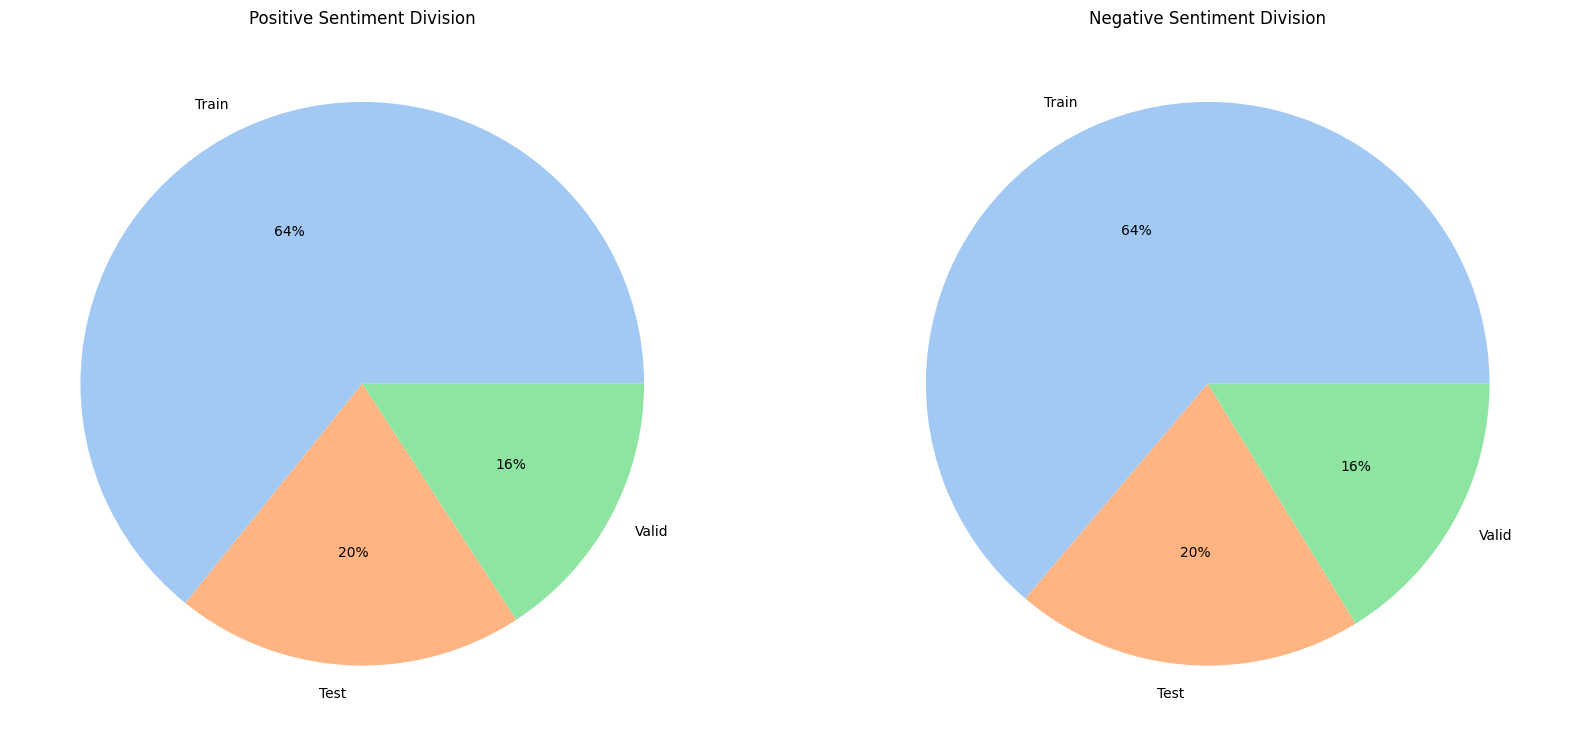

In [34]:
# Visualizing with the help of piecharts that the data remains balanced in all 3 datasets
plt.subplots(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(cts.iloc[0], labels = ['Train', 'Test', 'Valid'], colors = sns.color_palette('pastel')[0:3], autopct='%.0f%%')
plt.title('Positive Sentiment Division')

plt.subplot(1, 2, 2)
plt.pie(cts.iloc[1], labels = ['Train', 'Test', 'Valid'], colors = sns.color_palette('pastel')[0:3], autopct='%.0f%%')
plt.title('Negative Sentiment Division')

plt.show()

**Though, we can see from the table that the data is not perfectly divided but the difference is quite small, much less than even 1%. So, we will not be imbuing any kind of bias by the data division.**

# 6. Pre-Processing Pipeline



## (a) Transformers

For many years, the technique that had been widely adopted for NLP had been RNN or Sequential Models. But more recently, a new technique has been in the limelight in the form of the hot shot ChatGPT, Bard etc. which are employing a newer and more robust approach to solve the limitations of the earlier models. It is based on their ability to deal with large amounts of text with an **essential base on positional encoding, attention and self-attention.**

Based on this novel technique, certain models have been designed like the BERT, DistillBert, Roberta etc. which have been trained on huge corpuses of text data. In our approach, we will also be using one of these models to train our data because of their ability to deal with large text as well without memory errors with accuracy.

Specifically, we will be making use of a **Roberta Model which stands for 'Robustly Optimized BERT' i.e. it stands on top of the BERT model by google. The reason that this specific model was chosen is because of its optimization of the BERT in terms of the better results due to dynamic masking as well as the integration of a larger corpus.**

In the following lines of code, we use the AutoTokenizer from the hugging face library for tokenizing the text. The important thing to remember here is that we need to feed in the data having the same length which would require padding of shorter text length and truncation of the longer both of which can be easily performed using the in built function of the autotokenizer. Additionally, from the documentation of the model, we can see that it only processes text upto a length of 512. However, after testing the model for varius lengths, it was found that the text length of 128 in each batch would be effective.

In [35]:
## 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [36]:
def tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    return tokenizer(data["review"],padding = True , truncation = True, max_length=128)

def data_pipe(df):
    # The column is renamed as 'label' to use in the pre-built Roberta Model
    df1 = df
    df.rename(columns = {'sentiment':'label'} , inplace = True)
    ## Converting pandas to hugging face dataset to prepare the data as well as save it on drive to
    ## avoid wating memory
    df = Dataset.from_pandas(df)
    ## Padding the data with truncation to limit any input which nmay over shoot the maximum limit of the accepted input length of the model
    df = df.map(tokenize_dataset)
    return df

In [37]:
## The trainig and the validation data are passed through the pipeline to make the data as an acceptable Input form
## to be fed into a Roberta Model
training = data_pipe(training_data)
valid = data_pipe(validation_data)

Map:   0%|          | 0/1280 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

# 7. Model Roberta Fine-Tuning

After passing the data through the pipeline, we have it ready to be used with a Roberta Model. From the model summary, we can broadly see that the model has a considerably large number of parameters. Additionally, we can see that the **size of the text is quite large and feeding the tensors directly may result in the memory over load**. To avoid this, we convert the data into a **'tf dataset' to feed only a single batch which can optimize memory usage.** Additioanlly, it is also providing with added advantage of the ability to shuffle before the datset is fit on the model for fine-tuning.

The **optimizer used was Adam, the loss and metric used for training was the Sparse Categorical Cross-Entropy with a small learning rate as specified by the author for optimal usage**. The **model was trained on 3 epochs with a score of 94.91% on the training data and 89.40% on the validation data**.

In [38]:
# Load and compile our model
## 'roberta-base' , bert-base-uncased, distilbert-base-uncased
model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


In [39]:
tf_dataset = model.prepare_tf_dataset(training, batch_size=4, shuffle=True, tokenizer=tokenizer)
val_dataset = model.prepare_tf_dataset(valid, batch_size=4, shuffle=True, tokenizer=tokenizer)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [40]:
# Lower learning rates are often better for fine-tuning transformers
# lr 3e-5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.metrics.SparseCategoricalAccuracy())

model.fit(tf_dataset, validation_data= val_dataset , epochs = 3)

Epoch 1/3
320/320 [==============================] - 141s 233ms/step - loss: 0.4682 - sparse_categorical_accuracy: 0.7672 - val_loss: 0.3339 - val_sparse_categorical_accuracy: 0.8969
Epoch 2/3
320/320 [==============================] - 52s 161ms/step - loss: 0.2478 - sparse_categorical_accuracy: 0.9109 - val_loss: 0.3379 - val_sparse_categorical_accuracy: 0.8781
Epoch 3/3
320/320 [==============================] - 52s 163ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.3704 - val_sparse_categorical_accuracy: 0.9000


In [41]:
##### max_l = 150 , epc = 3 , learning_rate=1e-5  batch size =2
model.save_pretrained("my_imdb_model_1")

##### max_l = 128, 89.25%, batch size =2
# model.save_pretrained("*/my_imdb_model_2")

##### max_l = 128, batch size =4 ,89.7%
# model.save_pretrained("*/my_imdb_model_3")

# 8. Model Testing

The model testing was carried out on the test set with the conversion of the text converted to tensors before subsequently being fed to the model for prediction. **An F-1 score of 89.75% and accuracy score of 90.02% for our 3rd model** was achieved which had the following parameters:
- Learning Rate : 1e-5
- Loss Function : Sparse Categorical Entropy
- Training Metric: Sparse Categorical Accuracy
- Max Text Length : 128
- Batch Size : 4

In [42]:
## Since we have a binary classification problem, we will be using sigmoid function on the logits that are achieved to calculate the prob of each outcome
def sigmoid(x):
    return 1/(1+np.exp(-x))

## A simple function to apply the sigmoid function on the logits
def pred(x):
    temp = sigmoid(x)
    if temp[0] > temp[1]:
        return 0
    else:
        return 1

In [43]:
## Making a prediction pipeline
text = testing_data['review']
label = testing_data['sentiment']

res = []
## each review is fed to the model after passing through a tokenizer, the predicted value is then
## stored in a list called 'res' after passing the logits through a sigmoid function. Depending on
## the probability that we get, the review is graded as either positive or negative.
for i in text:
    ## Tokenizing the text before feeding it to the model for prediction
    t_text = tokenizer(i,padding = True , truncation = True, max_length =128, return_tensors = 'tf')
    res.append(pred(model(t_text)[0].numpy()[0]))

In [44]:
## a simple format to save the outcome in a json file

# ## Writing the test output res into a json file
# with open("/kaggle/working/test", "w") as fp:
#     json.dump(res, fp)


# with open("/kaggle/working/test", "r") as fp:
#     b = json.load(fp)

In [45]:
## from sklearn metrics, using accuracy, F-1 score as well as confusion matrix to study the result
accuracy_score(label , res) , f1_score(label , res)

(0.8725, 0.8702290076335878)

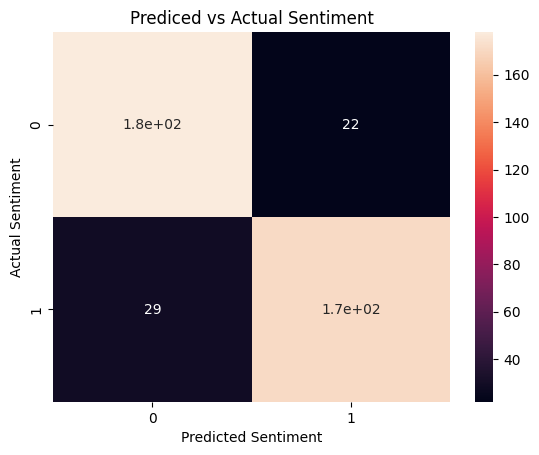

In [46]:
sns.heatmap(confusion_matrix(label , res) , annot = True)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Prediced vs Actual Sentiment')
plt.show()

# 9. Classifying the review comments from Youtube

In [47]:
df_ytb = pd.read_csv("/content/drive/MyDrive/Sentiment_Dataset/ytb_kingdom_of_us.csv")
#df_ytb = pd.read_csv("ytb_comments_family.csv")
df_ytb.head()
import re
import string

# Remove column name 'Unnamed: 0'
dfc = df_ytb.drop(['Unnamed: 0'], axis=1)
dfc.head()


def clean_html(text):
    clean=re.compile('<.*?>')
    cleantext=re.sub(clean,'',text)
    return cleantext

# first round of cleaning
def clean_text1(text):
    text=text.lower()
    text=re.sub('','',text)
    text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    return text

# second round of cleaning
def clean_text2(text):
    text=re.sub('[''"",,,]','',text)
    text=re.sub('\n','',text)
    return text

cleaned_html=lambda x:clean_html(x)
cleaned1=lambda x:clean_text1(x)
cleaned2=lambda x:clean_text2(x)

dfc['review'] = dfc['comment']
dfc['review']=pd.DataFrame(dfc.review.apply(cleaned_html))
dfc['review']=pd.DataFrame(dfc.review.apply(cleaned1))
dfc['review']=pd.DataFrame(dfc.review.apply(cleaned2))

#from nltk.corpus import stopwords
#import nltk
#from nltk.stem import PorterStemmer
#nltk.download('stopwords')


#stemmer = PorterStemmer()
#words = stopwords.words("english")

#dfc['processedtext'] = dfc['review'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

print(dfc.shape)
dfc.head(10)

first10comments = dfc.review.values

sentences = first10comments

(69, 3)


In [48]:
print(sentences)

['i went to school with the family they all had such energy then you would never have known what had happened'
 'einfach so eine emotionale doku bitte schaut immer auf eure liebsten und achtet auf symptome depressionen ist eine schlimme krankheit zeigt euren mitmenschen wie sehr ihr sie liebt man weiß nie was morgen geschieht'
 'sad but also beautiful story'
 'thankyou for sharing your personal experiences so sad for all your loss and how it affected u all individually you all have a wonderful mom stay strong'
 'quick psa some places can invoke an injunction that includes spending in the us that’s called conservatorship and it can be temporary or longer term plus option to mandate treatment by law due to illness that make the person temporarily or more chronically unable to make that choice themselves due to the illness so this includes illnesses that affect cognitive functioning sometimes these things can help other times they don’t and all services may not be available in all areas t

In [58]:
## Making a prediction pipeline
text = sentences
#label = testing_data['sentiment']

test_res = []
## each review is fed to the model after passing through a tokenizer, the predicted value is then
## stored in a list called 'res' after passing the logits through a sigmoid function. Depending on
## the probability that we get, the review is graded as either positive or negative.
for i in text:
    ## Tokenizing the text before feeding it to the model for prediction
    t_text = tokenizer(i,padding = True , truncation = True, max_length =128, return_tensors = 'tf')
    test_res.append(pred(model(t_text)[0].numpy()[0]))

In [59]:
print(test_res)

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]


In [57]:
text =[ 'I am having doubt over the originality of this movie', 'I had no feeling of bad for that movie', 'I donot feel bad anymore about the movie']
test_example = []
for i in text:
    ## Tokenizing the text before feeding it to the model for prediction
    t_text = tokenizer(i,padding = True , truncation = True, max_length =128, return_tensors = 'tf')
    test_example.append(pred(model(t_text)[0].numpy()[0]))

In [52]:
print(test_res)

[0, 1, 1]


In [60]:
type(sentences)

numpy.ndarray

In [61]:
test_res = np.array(test_res)

In [62]:
df = pd.DataFrame({"Comments" : sentences, "Labels" : test_res})
df.to_csv("Classified_Ytb_Labels.csv", index=False)

In [63]:
!cp Classified_Ytb_Labels.csv /content/drive/MyDrive/Sentiment_Dataset/

# 10. References

1. https://arxiv.org/pdf/1907.11692.pdf
2. https://daleonai.com/transformers-explained
3. https://huggingface.co/docs/datasets/use_with_tensorflow
4. https://huggingface.co/docs/transformers/model_doc/roberta